sample41_batch11_40_41_DE_stack_ok
   open and cluster images...
   done
   find leaf voxels...
[1, 38, 76, 113, 151, 188, 226, 263, 301, 338, 376, 413, 451, 488, 526, 563, 601, 638, 676, 713]
[[], [], [], [], [], [], [], [(233.78125, 311.34375), (285.03125, 313.90625), (317.0625, 293.40625), (310.65625, 252.40624999999997), (278.625, 231.90624999999997), (249.15625, 221.65624999999997), (214.5625, 221.65624999999997), (188.9375, 230.62499999999997), (195.34375, 263.9375), (209.4375, 289.5625)], [(226.09375, 326.71875), (276.0625, 329.28125), (310.65625, 308.78125), (313.21875, 280.59375), (310.65625, 248.56249999999997), (292.71875, 225.49999999999997), (258.125, 211.40624999999997), (217.125, 210.12499999999997), (179.96875, 211.40624999999997), (173.5625, 249.84374999999997), (187.65625, 297.25)], [(194.0625, 329.28125), (244.03125, 339.53125), (285.03125, 324.15625), (305.53125, 294.6875), (309.375, 260.09375), (302.96875, 219.09374999999997), (274.78125, 202.43749999999997), (237.

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:91: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:92: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


   done
   calculating features...


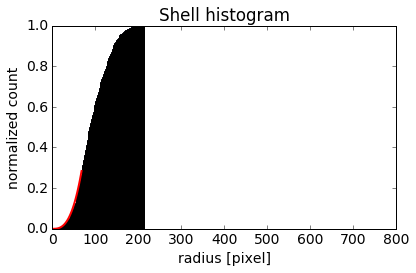

sample41_batch11_40_41_DE_stack_ok 0.161285949465 22719462.0 0.550834929648 2.87244389729 0.0200271353308 [ 0.11497109] [ 0.65982758] [ 0.95646134]


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:232: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 376 but corresponding boolean dimension is 375


In [1]:
import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
import pickle
from sklearn.cluster import KMeans
from skimage.measure import grid_points_in_poly
from scipy.interpolate import splprep, splrep, splev
from pydescriptors.compactness import hz as compactness_hz
from scipy.ndimage.measurements import center_of_mass
from scipy.optimize import curve_fit

%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

def func(x, C, D): 
    return C*x**D

#buds = ['T2','T3','Viburnum_batch12_sampleT6_redo_cropped','sample41_batch11_40_41_DE_stack_ok',\
#        'sample36_batch8_FGH_stack_ok','sample23_batch4_EF_stack_ok','sample17_batch3_IJ_stack_ok',\
#        'sample09_batch2_stack_ok','sample21_batch4_CD_stack_ok','sample10_batch2_stack_ok',\
#        'sample06_batch2_stack_ok','sample34_batch8_IJLK_stack_ok','sample38_batch10_BCD_stack_ok',\
#        'sample13_batch3_B_stack_m??ig','sample44_batch10_EFG_stack_ok','sample01_batch1_stack_cropped_ok',\
#        'sample15_batch5_DE_stack_m??ig','sample08_batch2_stack','sample19_batch3_EFGH_stack_ok',\
#        'sample20_batch4_AB_stack_ok']

buds = ['sample41_batch11_40_41_DE_stack_ok']

for d in buds:
    # open image files
    print d
    print '   open and cluster images...'

    files = []
    for file in glob.glob('image_stacks/'+d+'/*.ti*'):
        files.append(file)

    files.sort()

    im = np.array(Image.open(files[0]))

    image_stack = np.zeros([len(files),np.shape(im)[0],np.shape(im)[1]])
    bud_voxels = np.zeros([len(files),np.shape(im)[0],np.shape(im)[1]])
    leaf_voxels = np.zeros([len(files),np.shape(im)[0],np.shape(im)[1]])
    for i in range(len(files)):
        im = np.array(Image.open(files[i]))
        image_stack[i,:,:] = im
        cls = KMeans(2).fit_predict(im.reshape([np.prod(np.shape(im)),1]))            
        # make sure the background is 0, the bud is 1, clustering randomizes which one is which
        # assuming here that the corner pixel is always background
        if cls[0] != 0:
            cls ^= 1
        bud_voxels[i,:,:] = cls.reshape(np.shape(im))
    print '   done'

    # find all leaf voxels

    print '   find leaf voxels...'

    # load the clicks
    file_name = 'data_files/'+d+'_shell_leaf_boundaries_d1.dat'
    f = open(file_name,'r')
    [background_shell,shell_leaf,fs] = pickle.load(f)
    f.close()

    indx = fs[0].index('.')
    frames = [int(f[indx-4:indx]) for f in fs]
    
    print frames
    print shell_leaf
    
    # do the periodic spline interpolation in the x-y frame and collect 1000 points on each frame
    points = np.zeros([20,3,1000])
    for f in range(len(frames)):

        boundary = np.array(shell_leaf[f])
        if len(boundary)>0:
            boundary = np.append(boundary,boundary[0,:][None,:],axis=0)

            center = [np.sum(boundary[:,0])/len(boundary[:,0]),np.sum(boundary[:,1])/len(boundary[:,1])]

            tck, u = splprep(boundary.T, u=None, s=0.0, per=1) 

            u_new = np.linspace(u.min(), u.max(), 1000)
            x_new, y_new = splev(u_new, tck, der=0)

            phi = np.arctan2(y_new-center[1], x_new-center[0])/np.pi
            indx = np.where(phi == np.max(phi))[0]

            x_shift = np.append(x_new[indx:],x_new[:indx])
            y_shift = np.append(y_new[indx:],y_new[:indx])
            z_shift = np.zeros(len(x_new))+frames[f]

            points[f] = np.array([x_shift,y_shift,z_shift])    

    # do the vertical interpolation and collect the tcks for splev
    splev_x = []
    splev_y = []
    for i in range(1000):
        x = points[:,0,i]
        y = points[:,1,i]
        z = points[:,2,i]
        tckx = splrep(z[x>0],x[x>0])
        splev_x.append(tckx)

        tcky = splrep(z[x>0],y[x>0])
        splev_y.append(tcky)

    # go through the frames and plot the interpolated contours

    plot = True

    alpha = 0.6
    colors = [(0.0, 0.0, 0.0, 0e0),  # black
                (1.0, 0.0, 0.0, alpha)]  # red
    cmap1 = matplotlib.colors.ListedColormap(colors)
    colors = [(0.0, 0.0, 0.0, 0e0),  # black
                (0.0, 0.0, 1.0, alpha)]  # blue
    cmap2 = matplotlib.colors.ListedColormap(colors)

    f = 0
    for i in range(np.shape(image_stack)[0]):
        if plot:
            plt.figure(figsize=(6,6))
            plt.axis('equal')
            plt.title('blue: scale, red: leaf, uncolored: background')
            plt.xlabel('pixel coord.')
            plt.ylabel('pixel coord.')
            plt.imshow(image_stack[i,:,:].T,cmap='Greys_r',vmin=10000,vmax=33000)
        
        if (i == frames[f+1]) and (f < len(frames)-2):
            f = f + 1
        
        boundary = np.array(shell_leaf[f])
            
        if len(boundary) > 0:
            x_cont = np.zeros(1000)
            y_cont = np.zeros(1000)
            for j in range(1000):
                tck_x = splev_x[j]
                tck_y = splev_y[j]
                x_cont[j] = splev(i,tck_x)
                y_cont[j] = splev(i,tck_y)
            pixels_in_cont = grid_points_in_poly(np.shape(bud_voxels[i,:,:]),np.array([x_cont,y_cont]).T)
            pixels_in_cont = np.rint(pixels_in_cont == True)
            leaf_voxels[i,:,:] = bud_voxels[i,:,:]*pixels_in_cont

            if plot: 
                plt.imshow(leaf_voxels[i,:,:].T,cmap=cmap1)
                plt.imshow((bud_voxels[i,:,:]-leaf_voxels[i,:,:]).T,cmap=cmap2)

                if i == frames[f]-1:
                    plt.plot(boundary[:,0],boundary[:,1],'wo')
                if i == frames[f]:
                    plt.plot(boundary[:,0],boundary[:,1],'wo')
                if i == frames[f]+1:
                    plt.plot(boundary[:,0],boundary[:,1],'wo')
        else:
            if plot:
                plt.imshow(bud_voxels[i,:,:].T,cmap=cmap2)
        
        if plot:
            plt.xlim([0,np.shape(image_stack[i,:,:])[0]])
            plt.ylim([0,np.shape(image_stack[i,:,:])[1]])    
            plt.savefig('animation_border/interpolate/frame41'+str(i).zfill(4)+'.png',dpi=100)
            plt.close()

    # pickle dump the arrays
    file_name = 'data_files/segmented_'+d+'.dat'
    f = open(file_name,'w')
    pickle.dump([bud_voxels,leaf_voxels],f)
    f.close()
    print '   done'

    # calculate features

    print '   calculating features...'

    # nr of bud voxels
    nr_bud_vox = np.sum(bud_voxels)

    # leaf to bud volume ratio
    lf_to_bud = np.sum(leaf_voxels)/nr_bud_vox

    # compactness
    X,Y,Z = leaf_voxels.nonzero()
    comp = compactness_hz(X,Y,Z)

    # fractal dimension and normalized counts
    CoM = center_of_mass(leaf_voxels)

    scale = 2e0

    nr_radii = int(np.max(np.shape(leaf_voxels))/scale)
    radii = np.arange(nr_radii+1)*scale
    x,y,z = np.ogrid[-CoM[0]:np.shape(leaf_voxels)[0]-CoM[0], -CoM[1]:np.shape(leaf_voxels)[1]-CoM[1],-CoM[2]:np.shape(leaf_voxels)[2]-CoM[2]]

    count = np.zeros(len(radii))

    for i in range(nr_radii):
        mask_outer = x*x + y*y + z*z <= radii[i+1]**2e0
        count[i] = np.sum(leaf_voxels[mask_outer])

    if np.max(count) != np.sum(leaf_voxels):
        print 'problem with shell histo'
        print np.max(count), np.sum(leaf_voxels)
        raise ValueError

    max_rad = np.argmax(radii[count < np.max(count)])

    # fit power law
    [C,D], pcov = curve_fit(func, radii[1:max_rad/3], count[1:max_rad/3],bounds = ([0e0,1e0],[np.inf,3e0]))

    perr = np.sqrt(np.diag(pcov))

    plt.bar(radii[count < np.max(count)],1e0*count[count < np.max(count)]/np.max(count),width=scale)
    plt.plot(radii[1:max_rad/3],C*radii[1:max_rad/3]**D/np.max(count),'r',linewidth=2)
    plt.xlabel('radius [pixel]')
    plt.ylabel('normalized count')
    plt.title('Shell histogram')
    plt.tight_layout()
    plt.show()
    plt.close()

    
    file_name = 'data_files/shell_hist_'+d+'.dat'
    f = open(file_name,'w')
    pickle.dump([count,radii],f)
    f.close()
    
    print d,lf_to_bud,nr_bud_vox,comp,D,perr[1],count[radii[1:] == radii[int(max_rad/4e0)]]/np.max(count),\
    count[radii[1:] == radii[int(max_rad/2e0)]]/np.max(count),count[radii[1:] == radii[int(3e0*max_rad/4e0)]]/np.max(count)

In [7]:
# from ccv:


# coding: utf-8

import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
import pickle
from sklearn.cluster import KMeans
from skimage.measure import grid_points_in_poly
from scipy.interpolate import splprep, splrep, splev
from pydescriptors.compactness import hz as compactness_hz
from scipy.ndimage.measurements import center_of_mass
from scipy.optimize import curve_fit
from scipy.ndimage.interpolation import zoom

def func(x, C, D): 
    return C*x**D

# leaves too small - less than 3 leaf boundaries clicked: 'T2', 'T3', 'Viburnum_batch12_sampleT6_redo_cropped'
# done: 
buds = ['sample41_batch11_40_41_DE_stack_ok','sample36_batch8_FGH_stack_ok','sample23_batch4_EF_stack_ok',\
        'sample17_batch3_IJ_stack_ok',\
        'sample09_batch2_stack_ok','sample21_batch4_CD_stack_ok','sample10_batch2_stack_ok',\
        'sample06_batch2_stack_ok','sample34_batch8_IJLK_stack_ok','sample38_batch10_BCD_stack_ok',\
        'sample13_batch3_B_stack_m??ig','sample44_batch10_EFG_stack_ok','sample01_batch1_stack_cropped_ok',\
        'sample15_batch5_DE_stack_m??ig','sample08_batch2_stack','sample19_batch3_EFGH_stack_ok',\
        'sample20_batch4_AB_stack_ok']

for d in buds:
    # open image files
    print d
    print '   open and cluster images...'

    files = []
    for file in glob.glob('image_stacks/'+d+'/*.ti*'):
        files.append(file)

    files.sort()
    
    scale = False    

    im = np.array(Image.open(files[0]))
    if np.any(np.array([len(files),np.shape(im)[0],np.shape(im)[1]])>2000):
        print '   DOWNSCALING imagestack by a factor of 2!'
        scale = True
    
    if scale:
        im = zoom(im,0.5)
        image_stack = np.zeros([len(files)/2,np.shape(im)[0],np.shape(im)[1]])
        bud_voxels = np.zeros([len(files)/2,np.shape(im)[0],np.shape(im)[1]])
        leaf_voxels = np.zeros([len(files)/2,np.shape(im)[0],np.shape(im)[1]])
        for i in range(len(files)):
            if i%2 == 0:
                im = zoom(np.array(Image.open(files[i])),0.5)
                image_stack[i/2,:,:] = im
        # do the clustering on the whole image stack 
        cls = KMeans(2).fit_predict(image_stack.reshape([np.prod(np.shape(image_stack)),1]))            
        # make sure the background is 0, the bud is 1, clustering randomizes which one is which
        # assuming here that the corner pixel is always background
        if cls[0] != 0:
            cls ^= 1
        bud_voxels = cls.reshape(np.shape(image_stack))

    else:
        image_stack = np.zeros([len(files),np.shape(im)[0],np.shape(im)[1]])
        bud_voxels = np.zeros([len(files),np.shape(im)[0],np.shape(im)[1]])
        leaf_voxels = np.zeros([len(files),np.shape(im)[0],np.shape(im)[1]])
        for i in range(len(files)):
            im = np.array(Image.open(files[i]))
            image_stack[i,:,:] = im
        # do the clustering on the whole image stack 
        cls = KMeans(2).fit_predict(image_stack.reshape([np.prod(np.shape(image_stack)),1]))            
        # make sure the background is 0, the bud is 1, clustering randomizes which one is which
        # assuming here that the corner pixel is always background
        if cls[0] != 0:
            cls ^= 1
        bud_voxels = cls.reshape(np.shape(image_stack))

    print '   done'

    # find all leaf voxels

    print '   find leaf voxels...'

    # load the clicks
    file_name = 'data_files/'+d+'_shell_leaf_boundaries_d1.dat'
    f = open(file_name,'r')
    [background_shell,shell_leaf,fs] = pickle.load(f)
    f.close()

    indx = fs[0].index('.')
    frames = np.array([int(f[indx-4:indx]) for f in fs])
    if scale:
        frames = frames/2
        
    # do the periodic spline interpolation in the x-y frame and collect 1000 points on each frame
    points = np.zeros([20,3,1000])
    for f in range(len(frames)):

        boundary = np.array(shell_leaf[f])
        if scale:
            boundary = boundary / 2e0
        if len(boundary)>0:
            boundary = np.append(boundary,boundary[0,:][None,:],axis=0)

            center = [np.sum(boundary[:,0])/len(boundary[:,0]),np.sum(boundary[:,1])/len(boundary[:,1])]

            tck, u = splprep(boundary.T, u=None, s=0.0, per=1) 

            u_new = np.linspace(u.min(), u.max(), 1000)
            x_new, y_new = splev(u_new, tck, der=0)

            phi = np.arctan2(y_new-center[1], x_new-center[0])/np.pi
            indx = np.where(phi == np.max(phi))[0]

            x_shift = np.append(x_new[indx:],x_new[:indx])
            y_shift = np.append(y_new[indx:],y_new[:indx])
            z_shift = np.zeros(len(x_new))+frames[f]

            points[f] = np.array([x_shift,y_shift,z_shift])    

    # do the vertical interpolation and collect the tcks for splev
    splev_x = []
    splev_y = []
    for i in range(1000):
        x = points[:,0,i]
        y = points[:,1,i]
        z = points[:,2,i]
        #print len(x),len(z),len(x[x>0]),len(z[x>0])
        #print x
        #print z
        #print boundary
        tckx = splrep(z[x>0],x[x>0])
        splev_x.append(tckx)

        tcky = splrep(z[x>0],y[x>0])
        splev_y.append(tcky)

    # go through the frames and plot the interpolated contours

    plot = False

    alpha = 0.6
    colors = [(0.0, 0.0, 0.0, 0e0),  # black
                (1.0, 0.0, 0.0, alpha)]  # red
    cmap1 = matplotlib.colors.ListedColormap(colors)
    colors = [(0.0, 0.0, 0.0, 0e0),  # black
                (0.0, 0.0, 1.0, alpha)]  # blue
    cmap2 = matplotlib.colors.ListedColormap(colors)

    f = 0
    for i in range(np.shape(image_stack)[0]):
        if plot:
            plt.figure(figsize=(6,6))
            plt.axis('equal')
            plt.title('blue: scale, red: leaf, uncolored: background')
            plt.xlabel('pixel coord.')
            plt.ylabel('pixel coord.')
            plt.imshow(image_stack[i,:,:].T,cmap='Greys_r',vmin=10000,vmax=33000)

        if (i == frames[f+1]) and (f < len(frames)-2):
            f = f + 1

        boundary = np.array(shell_leaf[f])
        if scale:
            boundary = boundary / 2e0
        if len(boundary) > 0:
            x_cont = np.zeros(1000)
            y_cont = np.zeros(1000)
            for j in range(1000):
                tck_x = splev_x[j]
                tck_y = splev_y[j]
                x_cont[j] = splev(i,tck_x)
                y_cont[j] = splev(i,tck_y)
            pixels_in_cont = grid_points_in_poly(np.shape(bud_voxels[i,:,:]),np.array([x_cont,y_cont]).T)
            pixels_in_cont = np.rint(pixels_in_cont == True)
            leaf_voxels[i,:,:] = bud_voxels[i,:,:]*pixels_in_cont

            if plot: 
                plt.imshow(leaf_voxels[i,:,:].T,cmap=cmap1)
                plt.imshow((bud_voxels[i,:,:]-leaf_voxels[i,:,:]).T,cmap=cmap2)

                if i == frames[f]-1:
                    plt.plot(boundary[:,0],boundary[:,1],'wo')
                if i == frames[f]:
                    plt.plot(boundary[:,0],boundary[:,1],'wo')
                if i == frames[f]+1:
                    plt.plot(boundary[:,0],boundary[:,1],'wo')
        else:
            if plot:
                plt.imshow(bud_voxels[i,:,:].T,cmap=cmap2)

        if plot:
            plt.xlim([0,np.shape(image_stack[i,:,:])[0]])
            plt.ylim([0,np.shape(image_stack[i,:,:])[1]])    
            plt.savefig('animation_border/interpolate/frame'+str(i).zfill(4)+'.png',dpi=100)
            plt.close()

    # pickle dump the arrays
    file_name = 'data_files/segmented_'+d+'.dat'
    f = open(file_name,'wb')
    pickle.dump([bud_voxels,leaf_voxels],f)
    f.close()
    print '   done'

    # calculate features

    print '   calculating features...'

    # nr of bud voxels
    nr_bud_vox = np.sum(bud_voxels)

    # leaf to bud volume ratio
    lf_to_bud = np.sum(leaf_voxels)/nr_bud_vox

    # compactness
    X,Y,Z = leaf_voxels.nonzero()
    comp = compactness_hz(X,Y,Z)

    # fractal dimension and normalized counts
    CoM = center_of_mass(leaf_voxels)
    #print CoM
    #print np.any(leaf_voxels == 1)
    #print np.shape(np.where(leaf_voxels == 1)[0])
    #print np.where(leaf_voxels == 1)
    #print leaf_voxels
    scale = 2e0

    nr_radii = int(np.max(np.shape(leaf_voxels))/scale)
    radii = np.arange(nr_radii+1)*scale
    x,y,z = np.ogrid[-CoM[0]:np.shape(leaf_voxels)[0]-CoM[0], -CoM[1]:np.shape(leaf_voxels)[1]-CoM[1],-CoM[2]:np.shape(leaf_voxels)[2]-CoM[2]]

    count = np.zeros(len(radii))

    for i in range(nr_radii):
        mask_outer = x*x + y*y + z*z <= radii[i+1]**2e0
        count[i] = np.sum(leaf_voxels[mask_outer])

    if np.max(count) != np.sum(leaf_voxels):
        print 'problem with shell histo'
        print np.max(count), np.sum(leaf_voxels)
        raise ValueError

    max_rad = np.argmax(radii[count < np.max(count)])

    # fit power law
    #[C,D], pcov = curve_fit(func, radii[1:max_rad/3], count[1:max_rad/3],bounds = ([0e0,1e0],[np.inf,3e0]))
    [C,D], pcov = curve_fit(func, radii[1:max_rad/3], count[1:max_rad/3])

    perr = np.sqrt(np.diag(pcov))
    
    file_name = 'data_files/shell_hist_'+d+'.dat'
    f = open(file_name,'wb')
    pickle.dump([count,radii],f)
    f.close()
    
    print d,lf_to_bud,nr_bud_vox,comp,D,perr[1],count[radii[1:] == radii[int(max_rad/4e0)]]/np.max(count),    count[radii[1:] == radii[int(max_rad/2e0)]]/np.max(count),count[radii[1:] == radii[int(3e0*max_rad/4e0)]]/np.max(count)


sample41_batch11_40_41_DE_stack_ok
   open and cluster images...
   done
   find leaf voxels...


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:122: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:123: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


KeyboardInterrupt: 